In [ ]:
!pip install ucimlrepo

**1. Import Datasets**

In [ ]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
# fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# data (as pandas dataframes)
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

# metadata
print(breast_cancer_wisconsin_diagnostic.metadata)

# variable information
print(breast_cancer_wisconsin_diagnostic.variables.head())

#Diagnosis (M = malignant, B = benign)
pd.unique(y.values.ravel())


{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'ID': 230, 'type': 'NATIVE', 'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'venue': 'Electronic imaging', 'year': 1993, 'journal': None, 'DOI': '1

array(['M', 'B'], dtype=object)

**2. Handling Missing Values - Impute numerival columns with mean and categorical columns with mode**

No categorical columns found.


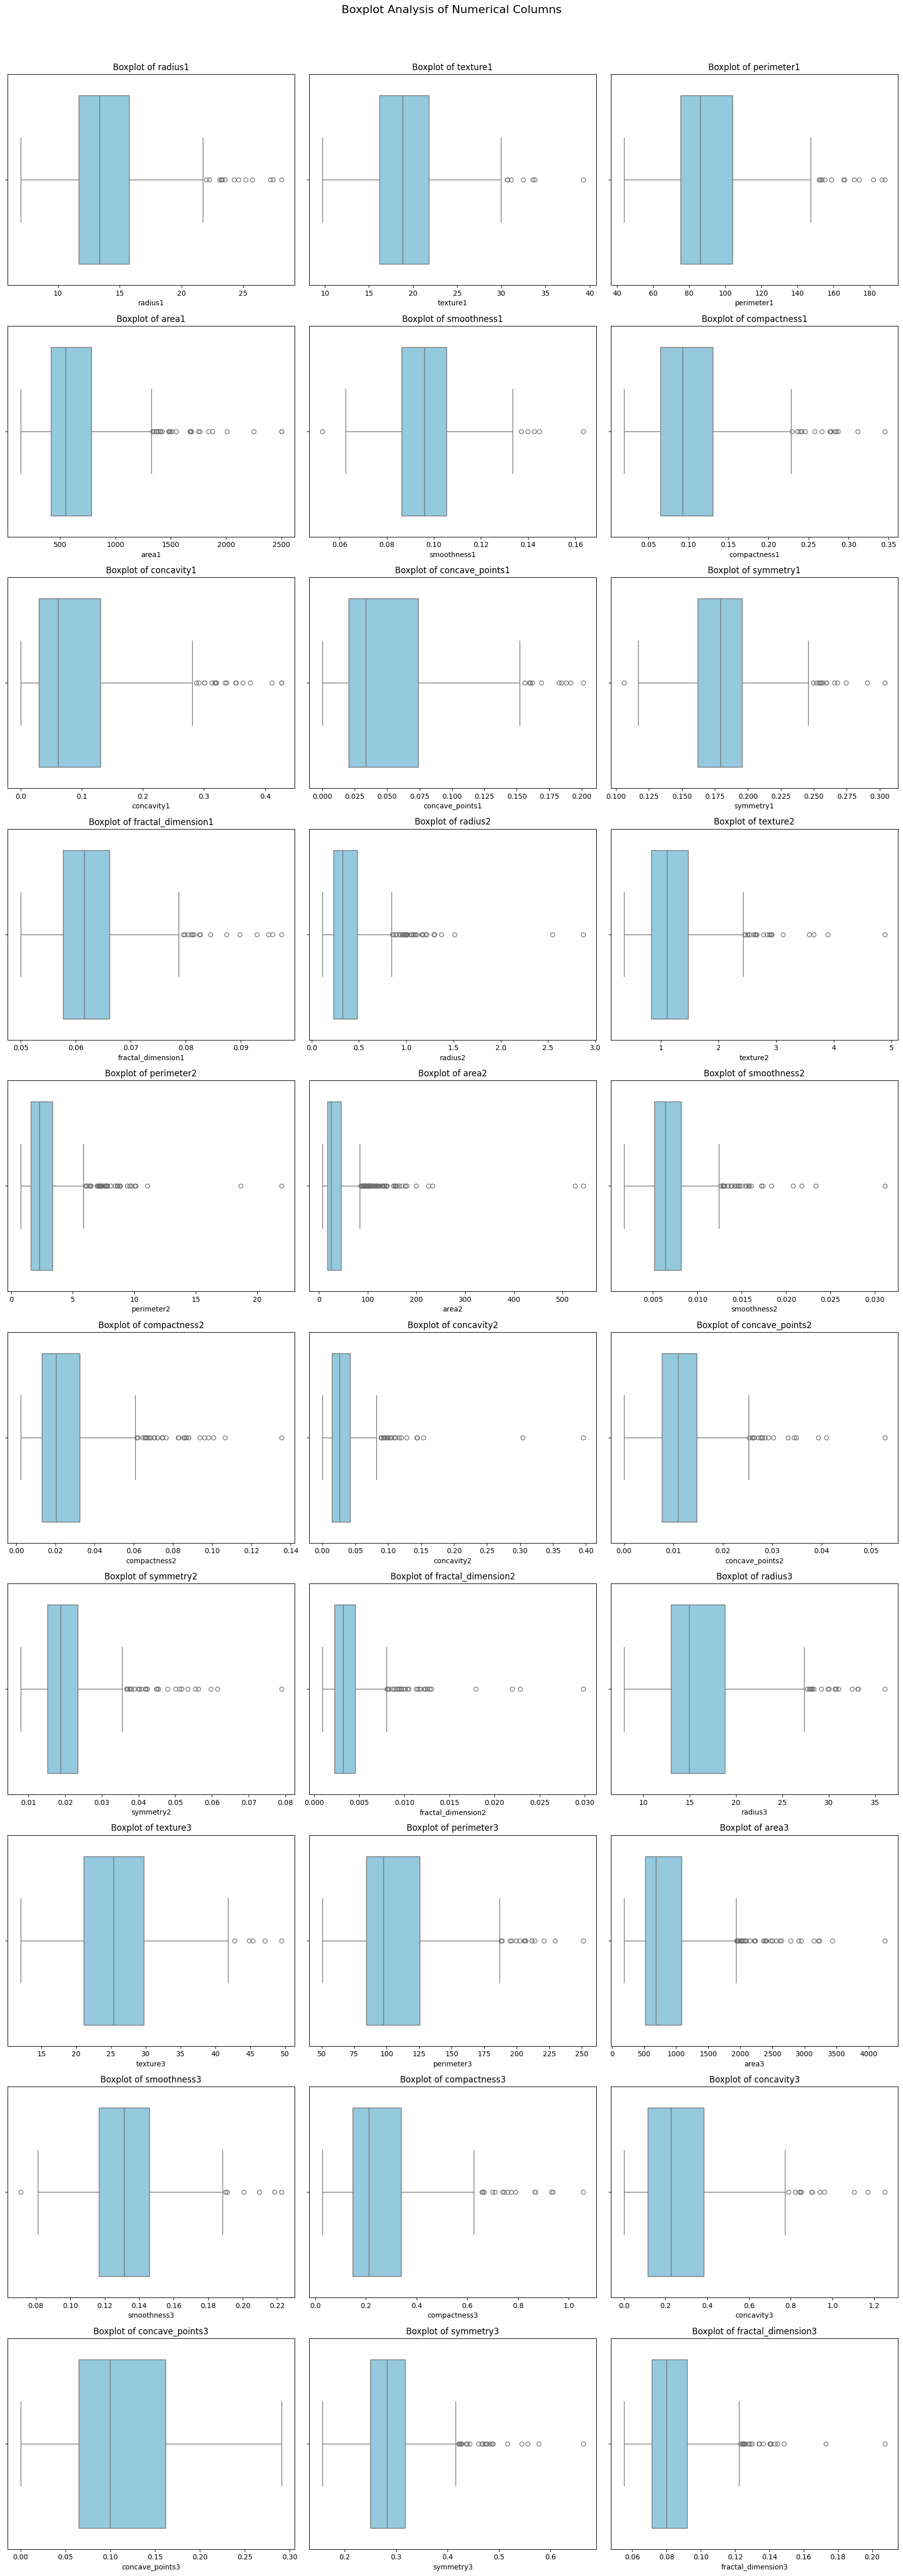

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# --- Step 1: Load Dataset ---
df = X

# --- Step 2: Impute Missing Values ---
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype == 'object':
            df[col].fillna(df[col].mode()[0], inplace=True)
        else:
            df[col].fillna(df[col].median(), inplace=True)

# --- Step 3: Identify Categorical Columns ---
categorical_cols = df.select_dtypes(include='object').columns.tolist()

# --- Step 4: Apply One-Hot Encoding using ColumnTransformer ---
if categorical_cols:
    print("Encoding categorical columns:", categorical_cols)

    column_transformer = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
        ],
        remainder='passthrough'  # Keep all other columns
    )

    transformed = column_transformer.fit_transform(df)
    feature_names = column_transformer.get_feature_names_out()

    df = pd.DataFrame(transformed, columns=feature_names)

else:
    print("No categorical columns found.")
    df = df.copy()

# --- Step 5: Boxplot Analysis (3 per row) ---
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_plots = len(numeric_cols)
cols_per_row = 3
rows = (num_plots + cols_per_row - 1) // cols_per_row

plt.figure(figsize=(6 * cols_per_row, 5 * rows))
for i, col in enumerate(numeric_cols):
    plt.subplot(rows, cols_per_row, i + 1)
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()

plt.suptitle("Boxplot Analysis of Numerical Columns", fontsize=16, y=1.02)
plt.show()


**3. Detecting Outliers and Capping them using IQR**


🔍 Capping outliers using IQR method:
radius1: 14 outliers capped
texture1: 7 outliers capped
perimeter1: 13 outliers capped
area1: 25 outliers capped
smoothness1: 6 outliers capped
compactness1: 16 outliers capped
concavity1: 18 outliers capped
concave_points1: 10 outliers capped
symmetry1: 15 outliers capped
fractal_dimension1: 15 outliers capped
radius2: 38 outliers capped
texture2: 20 outliers capped
perimeter2: 38 outliers capped
area2: 65 outliers capped
smoothness2: 30 outliers capped
compactness2: 28 outliers capped
concavity2: 22 outliers capped
concave_points2: 19 outliers capped
symmetry2: 27 outliers capped
fractal_dimension2: 28 outliers capped
radius3: 17 outliers capped
texture3: 5 outliers capped
perimeter3: 15 outliers capped
area3: 35 outliers capped
smoothness3: 7 outliers capped
compactness3: 16 outliers capped
concavity3: 12 outliers capped
concave_points3: No outliers detected
symmetry3: 23 outliers capped
fractal_dimension3: 24 outliers capped


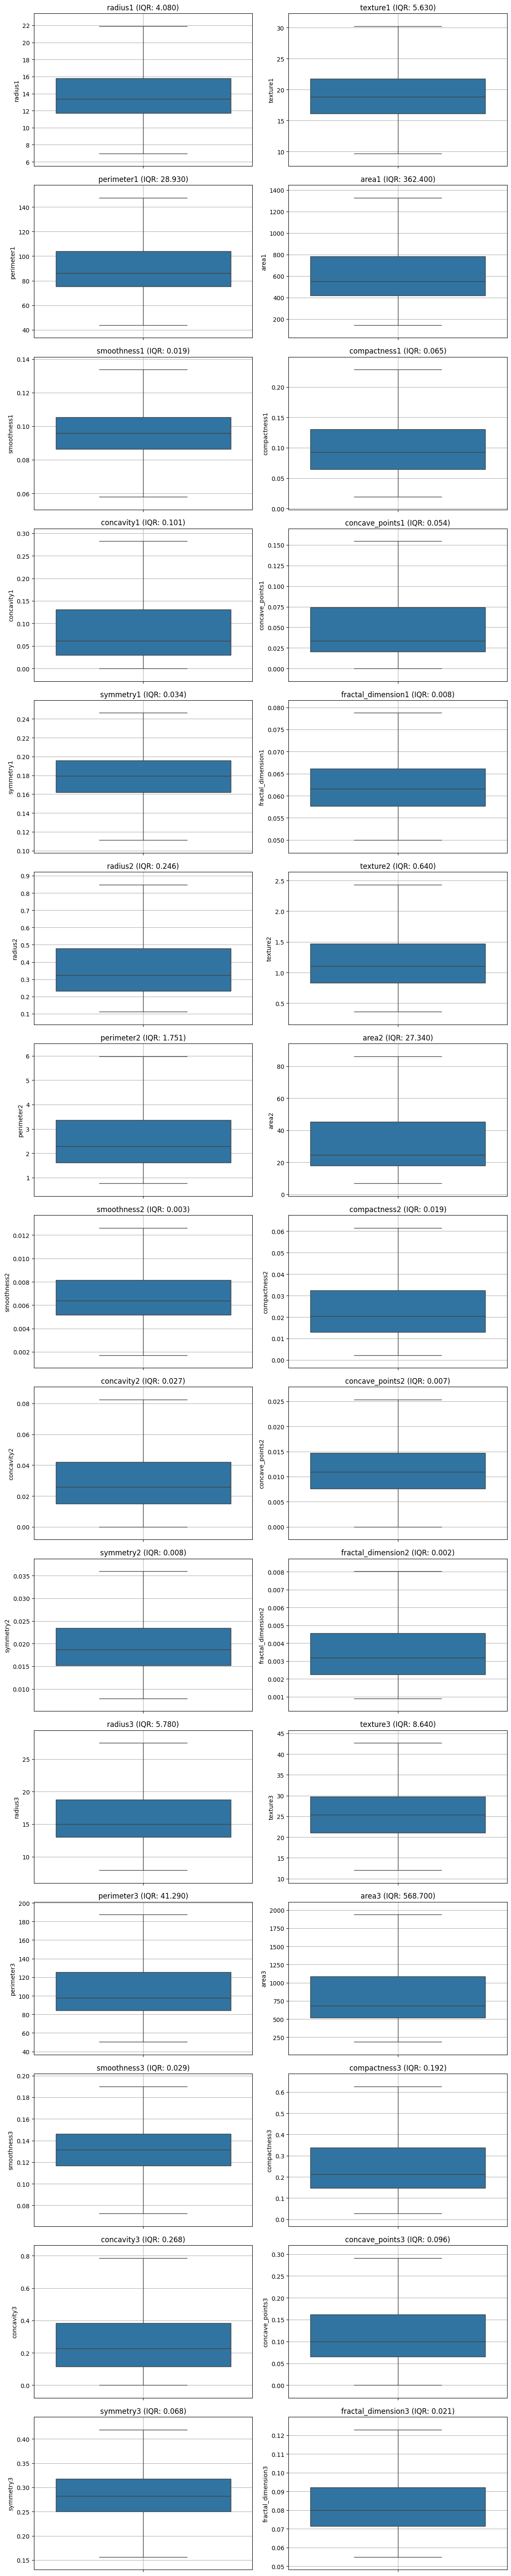

In [ ]:
# Create a copy to apply capping
capped_df = df.copy()

print("\n🔍 Capping outliers using IQR method:")

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

    if not outliers.empty:
        print(f"{col}: {len(outliers)} outliers capped")
        capped_df[col] = np.where(capped_df[col] < lower_bound, lower_bound,
                            np.where(capped_df[col] > upper_bound, upper_bound, capped_df[col]))
    else:
        print(f"{col}: No outliers detected")



import math


df = capped_df.copy()



def plot_boxplots_grid(df, columns, per_row=2):
    n = len(columns)
    rows = (n + per_row - 1) // per_row
    fig, axes = plt.subplots(rows, per_row, figsize=(6 * per_row, 4 * rows))

    # Flatten axes array in case of multiple rows
    axes = axes.flatten()

    for idx, col in enumerate(columns):
        data = df[col].dropna()
        Q1 = np.percentile(data, 25)
        Q3 = np.percentile(data, 75)
        IQR = Q3 - Q1
        spread = data.max() - data.min()

        # Avoid completely flat plots by scaling y-limits
        padding = spread * 0.1 if spread > 0 else 1e-3
        y_min = data.min() - padding
        y_max = data.max() + padding

        ax = axes[idx]
        sns.boxplot(y=data, ax=ax)
        ax.set_ylim([y_min, y_max])
        ax.set_title(f'{col} (IQR: {IQR:.3f})')
        ax.grid(True)

    # Hide any unused subplots
    for i in range(n, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
plot_boxplots_grid(df, numerical_columns)


**4. Normalisation**


🧪 Normalizing Numerical Columns Based on Distribution and Outliers:

radius1: No outliers and not Gaussian → Min-Max normalization applied
texture1: No outliers and not Gaussian → Min-Max normalization applied
perimeter1: No outliers and not Gaussian → Min-Max normalization applied
area1: No outliers and not Gaussian → Min-Max normalization applied
smoothness1: No outliers and not Gaussian → Min-Max normalization applied
compactness1: No outliers and not Gaussian → Min-Max normalization applied
concavity1: No outliers and not Gaussian → Min-Max normalization applied
concave_points1: No outliers and not Gaussian → Min-Max normalization applied
symmetry1: No outliers and not Gaussian → Min-Max normalization applied
fractal_dimension1: No outliers and not Gaussian → Min-Max normalization applied
radius2: No outliers and not Gaussian → Min-Max normalization applied
texture2: No outliers and not Gaussian → Min-Max normalization applied
perimeter2: No outliers and not Gaussian → Min-Max nor

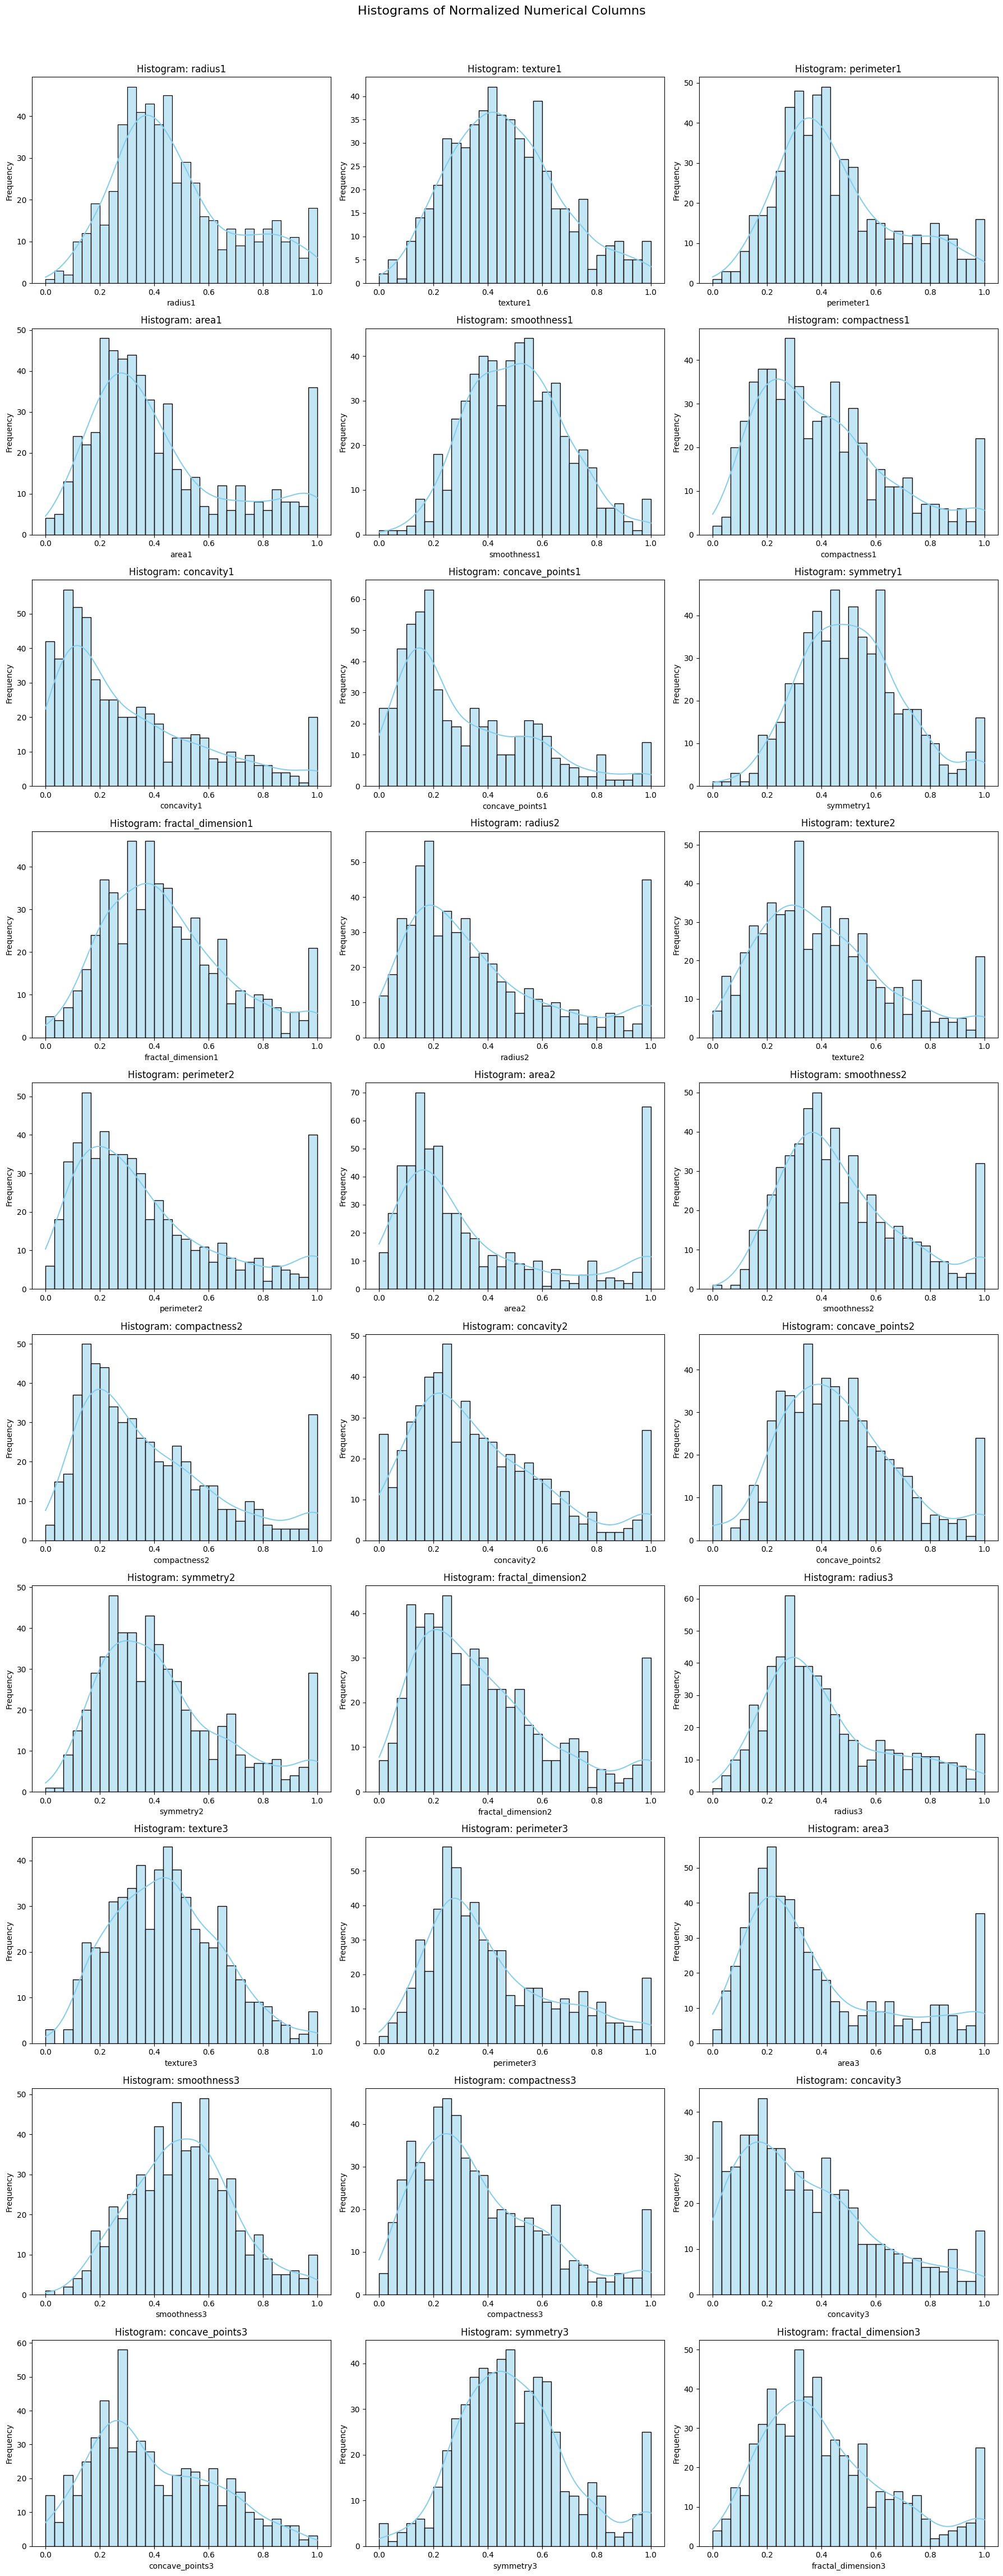

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore, normaltest
from sklearn.preprocessing import MinMaxScaler

# --- Step 1: Get Numerical Columns ---
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()

# --- Step 2: Create New DataFrame for Normalized Data ---
normalized_df = df.copy()

print("\n🧪 Normalizing Numerical Columns Based on Distribution and Outliers:\n")

# --- Step 3: Normalize Each Column Based on Condition ---
for col in numeric_cols:
    data = df[col]

    # Detect outliers using Z-score
    z_scores = zscore(data)
    outliers = np.where(np.abs(z_scores) > 3)[0]

    # Test for normal distribution
    stat, p_value = normaltest(data)

    if len(outliers) > 0 or p_value > 0.05:
        # Apply Z-score normalization
        normalized_df[col] = zscore(data)
        print(f"{col}: Outliers or normal distribution → Z-score normalization applied")
    else:
        # Apply Min-Max normalization
        scaler = MinMaxScaler()
        normalized_df[col] = scaler.fit_transform(data.values.reshape(-1, 1))
        print(f"{col}: No outliers and not Gaussian → Min-Max normalization applied")


# --- Plot Histograms After Normalization (3 per row) ---


cols_per_row = 3
num_plots = len(numeric_cols)
rows = (num_plots + cols_per_row - 1) // cols_per_row

plt.figure(figsize=(6 * cols_per_row, 4.5 * rows))
for i, col in enumerate(numeric_cols):
    plt.subplot(rows, cols_per_row, i + 1)
    sns.histplot(normalized_df[col], bins=30, kde=True, color='skyblue')
    plt.title(f'Histogram: {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()

plt.suptitle("Histograms of Normalized Numerical Columns", fontsize=16, y=1.02)
plt.show()


**5. Train, Test Split and Model building**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import (
    accuracy_score, recall_score, f1_score, confusion_matrix,
    classification_report, matthews_corrcoef, roc_auc_score,
    roc_curve
)

# --- Step 1: Split dataset ---
X = df

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)




In [ ]:
!pip install xgboost


[INFO] Starting hyperparameter tuning for Decision Tree...
[INFO] Finished hyperparameter tuning for Decision Tree. Best params: {'min_samples_split': 10, 'min_samples_leaf': 8, 'max_depth': 10, 'criterion': 'log_loss'}
[INFO] Performing CV accuracy check for Decision Tree...
[INFO] Decision Tree Test Accuracy=0.9298, Test F1=0.9285
[INFO] Decision Tree done. Test Accuracy=0.9298, Test F1=0.9285

[INFO] Starting hyperparameter tuning for AdaBoost...
[INFO] Finished hyperparameter tuning for AdaBoost. Best params: {'n_estimators': 200, 'learning_rate': 1.0, 'estimator': DecisionTreeClassifier(max_depth=2, random_state=42)}
[INFO] Performing CV accuracy check for AdaBoost...
[INFO] AdaBoost Test Accuracy=0.9649, Test F1=0.9645
[INFO] AdaBoost done. Test Accuracy=0.9649, Test F1=0.9645

[INFO] Starting hyperparameter tuning for Gradient Boosting...
[INFO] Finished hyperparameter tuning for Gradient Boosting. Best params: {'subsample': 0.6, 'n_estimators': 200, 'max_depth': 4, 'learning_r

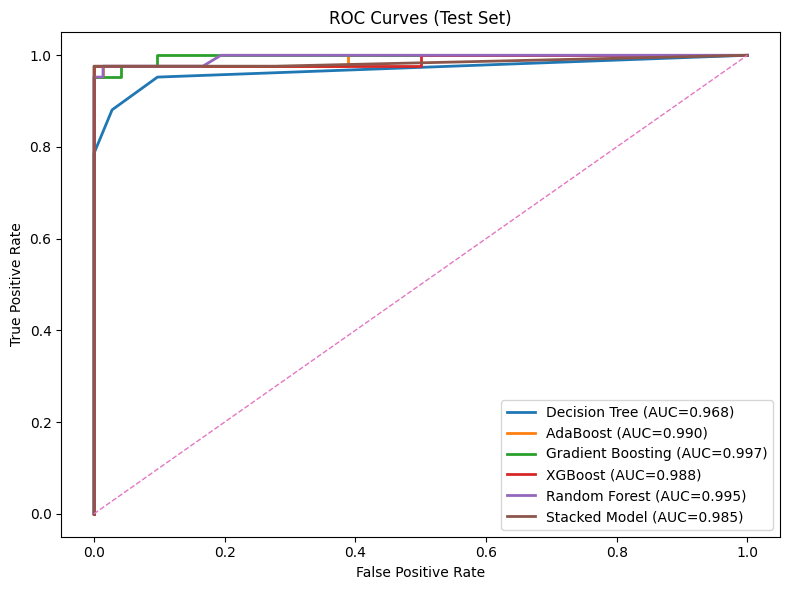

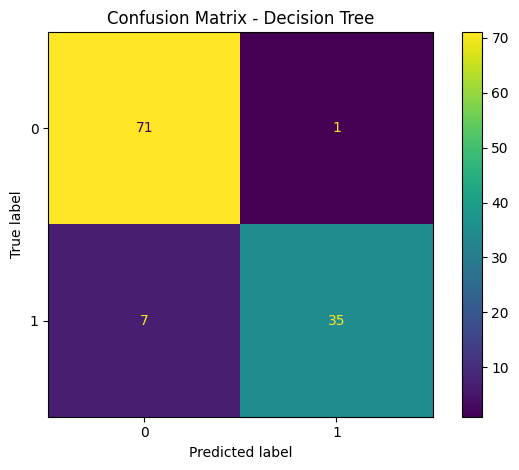

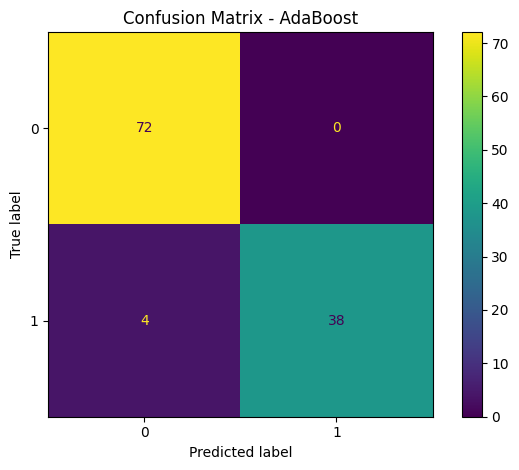

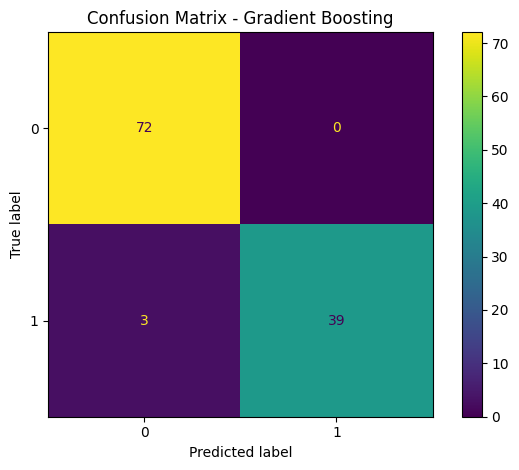

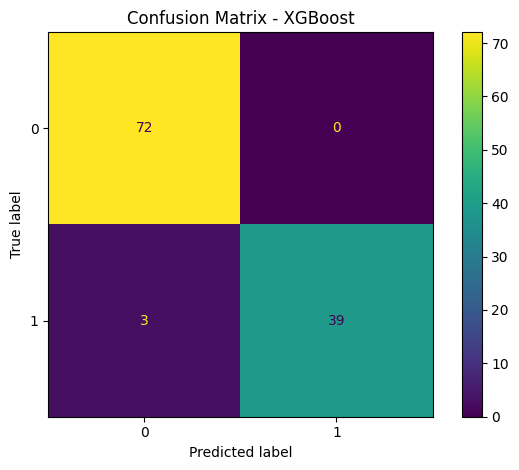

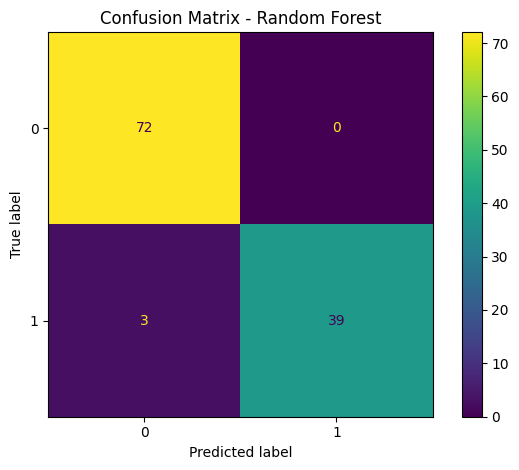

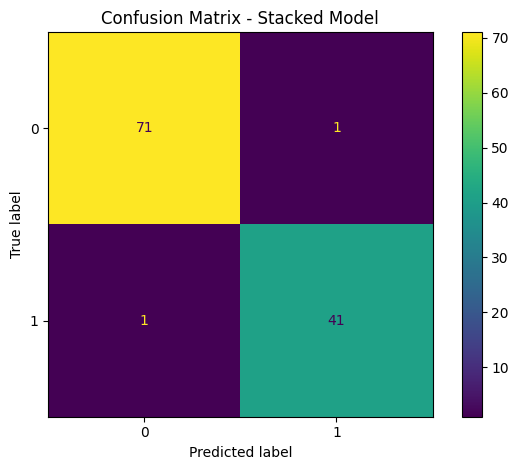

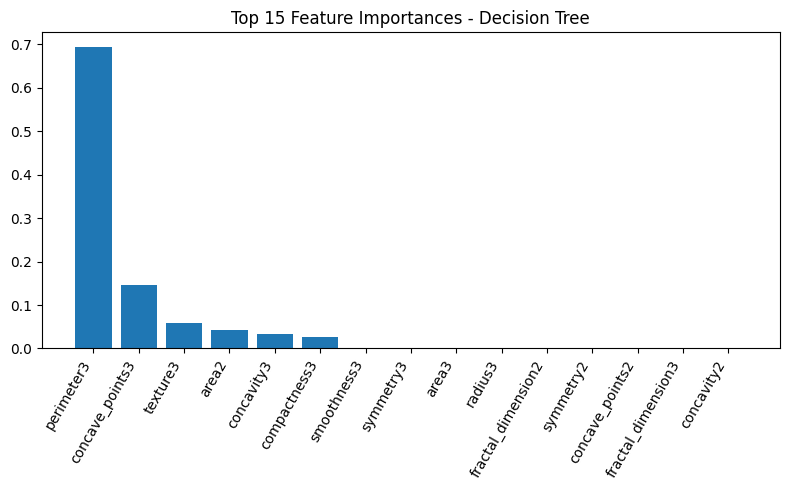

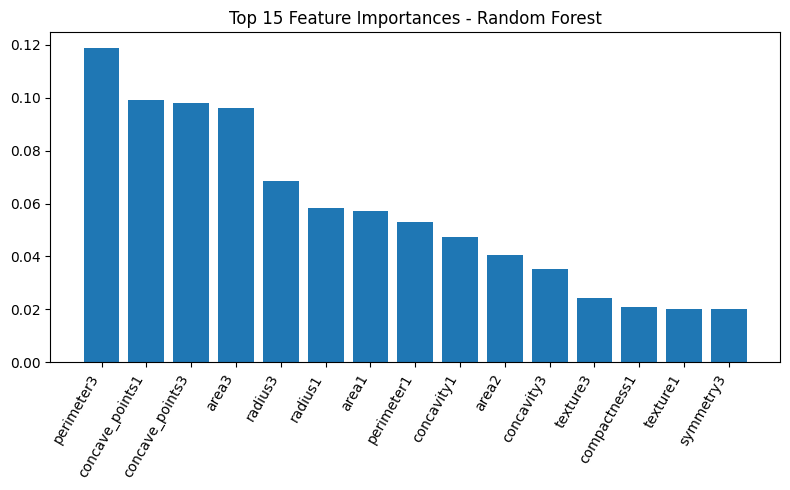

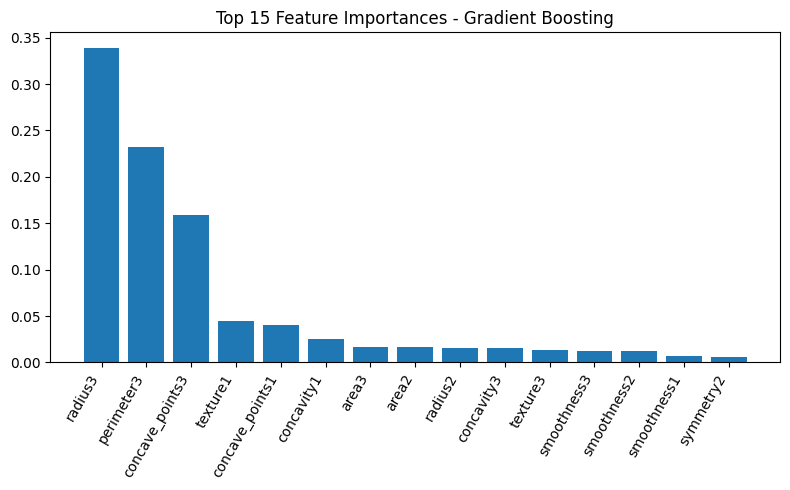

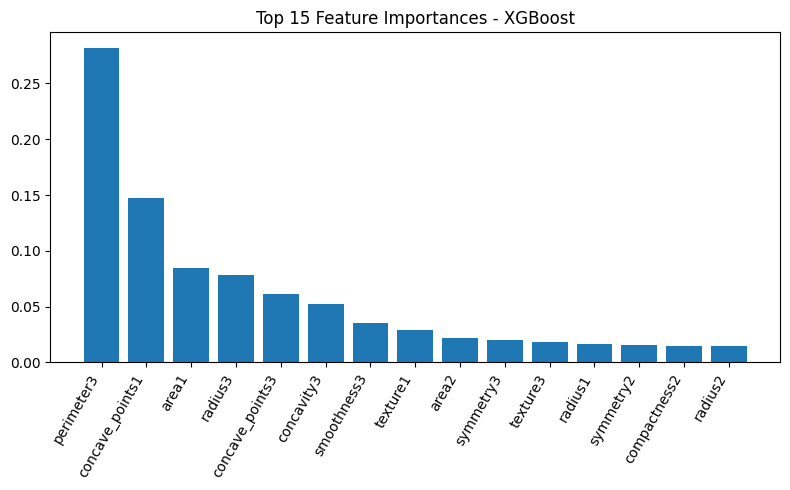


=== Test Set Summary (Best Estimators) ===
            model  test_accuracy  test_f1
    Stacked Model       0.982456 0.982456
Gradient Boosting       0.973684 0.973465
          XGBoost       0.973684 0.973465
    Random Forest       0.973684 0.973465
         AdaBoost       0.964912 0.964509
    Decision Tree       0.929825 0.928529

=== Observations & Conclusions ===


KeyError: 'test_auc'

In [ ]:

from tqdm import tqdm  # Progress bar for inner loops (optional pip install tqdm)
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, roc_curve, auc,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)

# Base & ensemble models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

# XGBoost
try:
    from xgboost import XGBClassifier
except Exception as e:
    raise ImportError(
        "xgboost is required. Please install with: pip install xgboost"
    )

import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 0) ASSUMPTIONS & SAFETY NETS
# ------------------------------------------------------------
# You must already have X_train, X_test, y_train, y_test in memory.
# Handle feature names (for importances)
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

def _feature_names(X):
    if hasattr(X, "columns"):
        return list(X.columns)
    return [f"f{i}" for i in range(X.shape[1])]

feature_names = _feature_names(X_train)

# Identify numeric columns for scaling when using SVM in stacking
if hasattr(X_train, "select_dtypes"):
    num_cols = list(X_train.select_dtypes(include=[np.number]).columns)
else:
    # Assume all numeric if numpy arrays
    num_cols = list(range(X_train.shape[1]))

numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
preprocess_for_svm = ColumnTransformer(
    transformers=[("num", numeric_transformer, num_cols)],
    remainder="passthrough",
)

# 5-Fold CV setup
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Utility for safe predict_proba / decision_function
def _predict_scores(clf, X):
    if hasattr(clf, "predict_proba"):
        return clf.predict_proba(X)[:, 1]
    if hasattr(clf, "decision_function"):
        s = clf.decision_function(X)
        # map to 0-1 via min-max if needed for AUC; monotonic transform preserves AUC ordering
        s = (s - s.min()) / (s.max() - s.min() + 1e-12)
        return s
    # worst case, return hard predictions as scores (AUC less meaningful)
    return clf.predict(X)

# Collectors for tables
tbl1_dt = []
tbl2_ada = []
tbl3_gb = []
tbl4_xgb = []
tbl5_rf = []
tbl6_stack = []
tbl7_cv = []
from sklearn.metrics import accuracy_score, f1_score

def _eval_on_test(name, model, X_test=X_test, y_test=y_test):
    """
    Evaluate a trained model on the test set.

    Returns a dict with test accuracy and F1 score.
    """
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")  # use weighted for multiclass
    print(f"[INFO] {name} Test Accuracy={acc:.4f}, Test F1={f1:.4f}")
    return {"model": name, "test_accuracy": acc, "test_f1": f1}

# ------------------------------------------------------------
# 1) DEFINE MODELS & HYPERPARAMETER SEARCH SPACES
# ------------------------------------------------------------

# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [None, 2, 3, 4, 5, 6, 8, 10, 15],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4, 8],
}
dt_search = RandomizedSearchCV(
    dt, dt_grid, n_iter=40, scoring="f1", n_jobs=-1, cv=cv5, random_state=42, refit=True, verbose=0
)

# AdaBoost (with DecisionTree base/estimator)
ada = AdaBoostClassifier(random_state=42)
# Newer sklearn uses 'estimator' instead of 'base_estimator'
ada_grid = {
    "n_estimators": [50, 75, 100, 150, 200],
    "learning_rate": [0.01, 0.05, 0.1, 0.3, 1.0],
    "estimator": [DecisionTreeClassifier(max_depth=d, random_state=42) for d in [1, 2, 3]]
}
ada_search = RandomizedSearchCV(
    ada, ada_grid, n_iter=30, scoring="f1", n_jobs=-1, cv=cv5, random_state=42, refit=True
)

# Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
gb_grid = {
    "n_estimators": [50, 75, 100, 150, 200],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [1, 2, 3, 4],
    "subsample": [0.6, 0.8, 1.0],
}
gb_search = RandomizedSearchCV(
    gb, gb_grid, n_iter=35, scoring="f1", n_jobs=-1, cv=cv5, random_state=42, refit=True
)

# XGBoost
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    random_state=42,
    use_label_encoder=False
)
xgb_grid = {
    "n_estimators": [100, 200, 300, 500],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [2, 3, 4, 5, 6],
    "gamma": [0, 0.5, 1.0],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}
xgb_search = RandomizedSearchCV(
    xgb, xgb_grid, n_iter=40, scoring="f1", n_jobs=-1, cv=cv5, random_state=42, refit=True
)

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf_grid = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [None, 3, 5, 7, 10, 15],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_features": ["sqrt", "log2", 0.5, None],
    "min_samples_split": [2, 5, 10, 20],
}
rf_search = RandomizedSearchCV(
    rf, rf_grid, n_iter=40, scoring="f1", n_jobs=-1, cv=cv5, random_state=42, refit=True
)

# Stacking: SVM (needs scaling), NaiveBayes, DecisionTree
stack_base = [
    ("svm", Pipeline([("prep", preprocess_for_svm), ("svc", SVC(probability=True, random_state=42))])),
    ("nb", GaussianNB()),
    ("dt", DecisionTreeClassifier(random_state=42)),
]
stack = StackingClassifier(
    estimators=stack_base,
    final_estimator=LogisticRegression(max_iter=500, random_state=42),
    stack_method="predict_proba",
    n_jobs=-1,
    passthrough=False
)
# Tune SVM C/gamma via nested params, and choose final estimator type
stack_grid = [
    {
        "final_estimator": [LogisticRegression(max_iter=500, random_state=42)],
        "svm__svc__C": [0.1, 1, 10],
        "svm__svc__gamma": ["scale", "auto"],
        "dt__max_depth": [None, 3, 5],
    },
    {
        "final_estimator": [RandomForestClassifier(n_estimators=200, random_state=42)],
        "svm__svc__C": [0.1, 1, 10],
        "svm__svc__gamma": ["scale", "auto"],
        "dt__max_depth": [None, 3, 5],
    },
]
stack_search = GridSearchCV(
    stack, stack_grid, scoring="f1", n_jobs=-1, cv=cv5, refit=True
)


# ------------------------------------------------------------
# 2) FIT SEARCHES & LOG TABLES 1–6 (with progress printing)
# ------------------------------------------------------------
# Collector for overall test results
results_summary = []

def _fit_and_log(search, name, table_collector, cols_for_table):
    print(f"\n[INFO] Starting hyperparameter tuning for {name}...")
    search.fit(X_train, y_train)
    print(f"[INFO] Finished hyperparameter tuning for {name}. Best params: {search.best_params_}")

    best = search.best_estimator_
    cvres = pd.DataFrame(search.cv_results_)
    param_cols = [c for c in cvres.columns if c.startswith("param_")]
    keep = ["mean_test_score", "std_test_score", "rank_test_score"] + param_cols
    slim = cvres[keep].sort_values("rank_test_score")
    slim = slim.rename(columns={"mean_test_score": "F1 (CV)", "std_test_score": "F1 std (CV)"})
    renamer = {f"param_{p}": p for p in cols_for_table if f"param_{p}" in slim.columns}
    slim = slim.rename(columns=renamer)

    print(f"[INFO] Performing CV accuracy check for {name}...")
    cv_acc = cross_val_score(best, X_train, y_train, cv=cv5, scoring="accuracy", n_jobs=-1)
    best_row = slim.iloc[0:1].copy()
    best_row["Accuracy"] = cv_acc.mean()
    best_row = best_row.rename(columns={"F1 (CV)": "F1 Score"})
    visible = [c for c in cols_for_table if c in best_row.columns]
    visible += [c for c in ["Accuracy", "F1 Score"] if c in best_row.columns]
    table_collector.append(best_row[visible])

    r = _eval_on_test(name, best)
    results_summary.append(r)
    print(f"[INFO] {name} done. Test Accuracy={r['test_accuracy']:.4f}, Test F1={r['test_f1']:.4f}")
    return best, slim

# Decision Tree -> Table 1
dt_best, dt_cvres = _fit_and_log(dt_search, "Decision Tree", tbl1_dt, cols_for_table=["criterion", "max_depth"])

# AdaBoost -> Table 2
ada_best, ada_cvres = _fit_and_log(ada_search, "AdaBoost", tbl2_ada, cols_for_table=["n_estimators", "learning_rate"])

# Gradient Boosting -> Table 3
gb_best, gb_cvres = _fit_and_log(gb_search, "Gradient Boosting", tbl3_gb, cols_for_table=["n_estimators", "learning_rate", "max_depth"])

# XGBoost -> Table 4
xgb_best, xgb_cvres = _fit_and_log(xgb_search, "XGBoost", tbl4_xgb, cols_for_table=["n_estimators", "learning_rate", "max_depth", "gamma"])

# Random Forest -> Table 5
rf_best, rf_cvres = _fit_and_log(rf_search, "Random Forest", tbl5_rf, cols_for_table=["n_estimators", "max_depth", "criterion"])

# Stacking -> Table 6
print("\n[INFO] Starting hyperparameter tuning for Stacking Classifier...")
stack_search.fit(X_train, y_train)
print(f"[INFO] Finished Stacking. Best params: {stack_search.best_params_}")
stack_best = stack_search.best_estimator_
cv_acc_stack = cross_val_score(stack_best, X_train, y_train, cv=cv5, scoring="accuracy", n_jobs=-1)
cv_f1_stack = cross_val_score(stack_best, X_train, y_train, cv=cv5, scoring="f1", n_jobs=-1)
tbl6_stack.append(pd.DataFrame([{
    "Base Models": "SVM, Naïve Bayes, Decision Tree",
    "Final Estimator": type(stack_search.best_params_["final_estimator"]).__name__,
    "Accuracy / F1 Score": f"{cv_acc_stack.mean():.4f} / {cv_f1_stack.mean():.4f}"
}]))
results_summary.append(_eval_on_test("Stacked Model", stack_best))
print(f"[INFO] Stacking done. Test Accuracy={results_summary[-1]['test_accuracy']:.4f}, Test F1={results_summary[-1]['test_f1']:.4f}")


# Materialize Tables 1–6
Table1_DecisionTree = pd.concat(tbl1_dt, ignore_index=True) if tbl1_dt else pd.DataFrame()
Table2_AdaBoost = pd.concat(tbl2_ada, ignore_index=True) if tbl2_ada else pd.DataFrame()
Table3_GradBoost = pd.concat(tbl3_gb, ignore_index=True) if tbl3_gb else pd.DataFrame()
Table4_XGBoost = pd.concat(tbl4_xgb, ignore_index=True) if tbl4_xgb else pd.DataFrame()
Table5_RandomForest = pd.concat(tbl5_rf, ignore_index=True) if tbl5_rf else pd.DataFrame()
Table6_Stacking = pd.concat(tbl6_stack, ignore_index=True) if tbl6_stack else pd.DataFrame()

print("\n=== Table 1: Decision Tree - Hyperparameter Tuning (Top Row) ===")
print(Table1_DecisionTree.to_string(index=False))
print("\n=== Table 2: AdaBoost - Hyperparameter Tuning (Top Row) ===")
print(Table2_AdaBoost.to_string(index=False))
print("\n=== Table 3: Gradient Boosting - Hyperparameter Tuning (Top Row) ===")
print(Table3_GradBoost.to_string(index=False))
print("\n=== Table 4: XGBoost - Hyperparameter Tuning (Top Row) ===")
print(Table4_XGBoost.to_string(index=False))
print("\n=== Table 5: Random Forest - Hyperparameter Tuning (Top Row) ===")
print(Table5_RandomForest.to_string(index=False))
print("\n=== Table 6: Stacked Ensemble - Hyperparameter Tuning ===")
print(Table6_Stacking.to_string(index=False))

# ------------------------------------------------------------
# 3) 5-FOLD CROSS-VALIDATION RESULTS -> Table 7 (Accuracy per fold)
# Use BEST estimators found above
# ------------------------------------------------------------
models_best = [
    ("Decision Tree", dt_best),
    ("AdaBoost", ada_best),
    ("Gradient Boosting", gb_best),
    ("XGBoost", xgb_best),
    ("Random Forest", rf_best),
    ("Stacked Model", stack_best),
]

rows = []
for name, model in models_best:
    scores = cross_val_score(model, X_train, y_train, cv=cv5, scoring="accuracy", n_jobs=-1)
    row = {"Model": name}
    for i, s in enumerate(scores, 1):
        row[f"Fold {i}"] = s
    row["Average Accuracy"] = scores.mean()
    rows.append(row)

Table7_CV = pd.DataFrame(rows)
print("\n=== Table 7: 5-Fold Cross-Validation Results (Training CV) ===")
print(Table7_CV.to_string(index=False))

# ------------------------------------------------------------
# 4) ROC CURVES & CONFUSION MATRICES (Test Set)
# ------------------------------------------------------------
def plot_roc_curves(model_dict, X_test, y_test):
    plt.figure(figsize=(8, 6))
    for name, clf in model_dict.items():
        y_score = _predict_scores(clf, X_test)
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC={roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], lw=1, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (Test Set)")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(model_dict, X_test, y_test):
    for name, clf in model_dict.items():
        y_pred = clf.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(values_format="d")
        plt.title(f"Confusion Matrix - {name}")
        plt.tight_layout()
        plt.show()

model_dict = {name: m for name, m in models_best}

# Plot ROC (only meaningful for binary)
if len(np.unique(y_test)) == 2:
    plot_roc_curves(model_dict, X_test, y_test)

plot_confusion_matrices(model_dict, X_test, y_test)

# ------------------------------------------------------------
# 5) FEATURE IMPORTANCE (DT, RF, GB, XGB)
# ------------------------------------------------------------
def show_importances(name, clf, feature_names, top_k=15):
    if hasattr(clf, "feature_importances_"):
        importances = clf.feature_importances_
    elif hasattr(clf, "named_steps"):
        # Some pipelines/stacking may wrap the estimator—try to find the attribute
        for step_name, step_est in getattr(clf, "named_steps", {}).items():
            if hasattr(step_est, "feature_importances_"):
                importances = step_est.feature_importances_
                break
        else:
            return
    else:
        return
    order = np.argsort(importances)[::-1][:top_k]
    plt.figure(figsize=(8, 5))
    plt.bar(range(len(order)), importances[order])
    plt.xticks(range(len(order)), [feature_names[i] for i in order], rotation=60, ha="right")
    plt.title(f"Top {top_k} Feature Importances - {name}")
    plt.tight_layout()
    plt.show()

show_importances("Decision Tree", dt_best, feature_names)
show_importances("Random Forest", rf_best, feature_names)
show_importances("Gradient Boosting", gb_best, feature_names)
show_importances("XGBoost", xgb_best, feature_names)

# ------------------------------------------------------------
# 6) AUTO-GENERATED OBSERVATIONS
# ------------------------------------------------------------
summary_df = pd.DataFrame(results_summary).sort_values("test_accuracy", ascending=False)
print("\n=== Test Set Summary (Best Estimators) ===")
print(summary_df.to_string(index=False))

def observations():
    best = summary_df.iloc[0]
    best_name = best["model"]
    # Compare DT vs Ensembles
    dt_row = summary_df[summary_df["model"] == "Decision Tree"].iloc[0]
    ensembles = summary_df[summary_df["model"] != "Decision Tree"]
    ensembles_mean_acc = ensembles["test_accuracy"].mean()
    rf_tuned_gain = None
    # Effect of tuning on RF: compare cross-val mean of tuned RF vs default RF
    rf_default = RandomForestClassifier(random_state=42)
    rf_default_scores = cross_val_score(rf_default, X_train, y_train, cv=cv5, scoring="accuracy", n_jobs=-1).mean()
    rf_tuned_scores = cross_val_score(rf_best, X_train, y_train, cv=cv5, scoring="accuracy", n_jobs=-1).mean()
    rf_tuned_gain = rf_tuned_scores - rf_default_scores

    # Generalization: gap between CV accuracy and test accuracy (absolute difference)
    gen_gaps = []
    for name, model in models_best:
        cv_acc = cross_val_score(model, X_train, y_train, cv=cv5, scoring="accuracy", n_jobs=-1).mean()
        test_acc = summary_df[summary_df["model"] == name]["test_accuracy"].values[0]
        gen_gaps.append((name, abs(cv_acc - test_acc)))
    gen_gaps = sorted(gen_gaps, key=lambda t: t[1])
    best_generalizer = gen_gaps[0][0]

    lines = []
    lines.append(f"Best accuracy on the test set: {best_name} (Acc={best['test_accuracy']:.4f}, F1={best['test_f1']:.4f}, AUC={best['test_auc']:.4f}).")
    lines.append(f"Ensembles vs Decision Tree: Mean ensemble accuracy={ensembles_mean_acc:.4f} vs Decision Tree accuracy={dt_row['test_accuracy']:.4f}.")
    lines.append(f"Random Forest tuning effect: ΔCV accuracy ≈ {rf_tuned_gain:.4f} (tuned - default).")
    lines.append(f"Best generalization (smallest CV–Test gap): {best_generalizer}.")
    # Stacking improvement over its base models (compare vs DT/SVM/NB individually where available)
    base_refs = ["Decision Tree"]  # NB & SVM individually not evaluated alone here
    stack_acc = summary_df[summary_df["model"] == "Stacked Model"]["test_accuracy"].values[0]
    improvements = []
    for b in base_refs:
        improvements.append((b, stack_acc - summary_df[summary_df["model"] == b]["test_accuracy"].values[0]))
    imp_str = ", ".join([f"{b}: {d:+.4f}" for b, d in improvements])
    lines.append(f"Stacking improvement vs base references → {imp_str}.")
    return "\n".join(lines)

print("\n=== Observations & Conclusions ===")
print(observations())


**Hyperparameter Trials for all models**

In [ ]:
import time
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

# Example: Assume X_train, X_test, y_train, y_test are already defined

def evaluate_model(model_class, param_sets, X_train, y_train, X_test, y_test):
    """
    Evaluate a model class on multiple hyperparameter sets.

    Args:
        model_class: Class of the estimator, e.g., DecisionTreeClassifier
        param_sets: List of dicts, each dict is a hyperparameter set
        X_train, y_train, X_test, y_test: Data

    Returns:
        DataFrame with results: hyperparameters, Accuracy, F1, Training Time
    """
    results = []

    for i, params in enumerate(param_sets, 1):
        print(f"[INFO] Evaluating {model_class.__name__}, set {i}: {params}")
        model = model_class(**params)

        start_time = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start_time

        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')  # macro for multi-class

        results.append({
            "Hyperparameters": params,
            "Accuracy": acc,
            "F1 (macro)": f1,
            "Training Time (s)": train_time
        })
        print(f"Accuracy: {acc:.4f}, F1: {f1:.4f}, Training Time: {train_time:.2f}s\n")

    return pd.DataFrame(results)

# ---------------------------------------
# 1) Decision Tree Example
# ---------------------------------------
from sklearn.tree import DecisionTreeClassifier

dt_param_sets = [
    {"criterion": "gini", "max_depth": 5, "min_samples_split": 2},
    {"criterion": "entropy", "max_depth": 10, "min_samples_split": 5},
    {"criterion": "log_loss", "max_depth": 8, "min_samples_split": 10},
]

dt_results = evaluate_model(DecisionTreeClassifier, dt_param_sets, X_train, y_train, X_test, y_test)
print("Decision Tree Results:\n", dt_results)

# ---------------------------------------
# 2) Random Forest Example
# ---------------------------------------
from sklearn.ensemble import RandomForestClassifier

rf_param_sets = [
    {"n_estimators": 100, "max_depth": 5, "criterion": "gini"},
    {"n_estimators": 200, "max_depth": 10, "criterion": "entropy"},
    {"n_estimators": 300, "max_depth": None, "criterion": "log_loss"},
]

rf_results = evaluate_model(RandomForestClassifier, rf_param_sets, X_train, y_train, X_test, y_test)
print("Random Forest Results:\n", rf_results)

# ---------------------------------------
# 3) Gradient Boosting Example
# ---------------------------------------
from sklearn.ensemble import GradientBoostingClassifier

gb_param_sets = [
    {"n_estimators": 100, "learning_rate": 0.05, "max_depth": 3},
    {"n_estimators": 150, "learning_rate": 0.1, "max_depth": 2},
    {"n_estimators": 200, "learning_rate": 0.01, "max_depth": 4},
]

gb_results = evaluate_model(GradientBoostingClassifier, gb_param_sets, X_train, y_train, X_test, y_test)
print("Gradient Boosting Results:\n", gb_results)

# ---------------------------------------
# 4) AdaBoost Example
# ---------------------------------------
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_param_sets = [
    {"n_estimators": 50, "learning_rate": 0.1, "estimator": DecisionTreeClassifier(max_depth=1)},
    {"n_estimators": 100, "learning_rate": 0.05, "estimator": DecisionTreeClassifier(max_depth=2)},
    {"n_estimators": 150, "learning_rate": 0.01, "estimator": DecisionTreeClassifier(max_depth=3)},
]

ada_results = evaluate_model(AdaBoostClassifier, ada_param_sets, X_train, y_train, X_test, y_test)
print("AdaBoost Results:\n", ada_results)

# ---------------------------------------
# 5) XGBoost Example
# ---------------------------------------
from xgboost import XGBClassifier

xgb_param_sets = [
    {"n_estimators": 100, "learning_rate": 0.05, "max_depth": 3},
    {"n_estimators": 200, "learning_rate": 0.1, "max_depth": 4},
    {"n_estimators": 300, "learning_rate": 0.01, "max_depth": 5},
]

xgb_results = evaluate_model(XGBClassifier, xgb_param_sets, X_train, y_train, X_test, y_test)
print("XGBoost Results:\n", xgb_results)


[INFO] Evaluating DecisionTreeClassifier, set 1: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}
Accuracy: 0.9298, F1: 0.9238, Training Time: 0.03s

[INFO] Evaluating DecisionTreeClassifier, set 2: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 5}
Accuracy: 0.9737, F1: 0.9713, Training Time: 0.05s

[INFO] Evaluating DecisionTreeClassifier, set 3: {'criterion': 'log_loss', 'max_depth': 8, 'min_samples_split': 10}
Accuracy: 0.9649, F1: 0.9619, Training Time: 0.05s

Decision Tree Results:
                                      Hyperparameters  Accuracy  F1 (macro)  \
0  {'criterion': 'gini', 'max_depth': 5, 'min_sam...  0.929825    0.923822   
1  {'criterion': 'entropy', 'max_depth': 10, 'min...  0.973684    0.971277   
2  {'criterion': 'log_loss', 'max_depth': 8, 'min...  0.964912    0.961911   

   Training Time (s)  
0           0.031666  
1           0.047766  
2           0.051443  
[INFO] Evaluating RandomForestClassifier, set 1: {'n_estimators': 100, 'm

**Exploring and evaluating different sets of stacked models**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


# Define base models
base_models_dict = {
    "SVM": SVC(probability=True, kernel='rbf', random_state=42),
    "NaiveBayes": GaussianNB(),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "RandomForest": RandomForestClassifier(random_state=42)
}

# Define final estimators
final_estimators_dict = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42)
}

# Define ensemble configurations for each row of your table
ensemble_configs = [
    (["SVM", "NaiveBayes", "DecisionTree"], "LogisticRegression"),
    (["SVM", "NaiveBayes", "DecisionTree"], "RandomForest"),
    (["SVM", "DecisionTree", "KNN"], "LogisticRegression")
]

# Prepare results table
results = []

for base_names, final_name in ensemble_configs:
    estimators = [(name, base_models_dict[name]) for name in base_names]
    final_estimator = final_estimators_dict[final_name]

    # Build stacking classifier
    model = StackingClassifier(estimators=estimators, final_estimator=final_estimator, cv=5)
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')  # weighted for multiclass

    results.append({
        "Base Models": ", ".join(base_names),
        "Final Estimator": final_name,
        "Accuracy": round(acc, 4),
        "F1 Score": round(f1, 4)
    })

# Display the table
df_results = pd.DataFrame(results)
print(df_results)


                     Base Models     Final Estimator  Accuracy  F1 Score
0  SVM, NaiveBayes, DecisionTree  LogisticRegression    0.9649    0.9645
1  SVM, NaiveBayes, DecisionTree        RandomForest    0.9474    0.9471
2         SVM, DecisionTree, KNN  LogisticRegression    0.9561    0.9558


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

# Default RF
rf_default = RandomForestClassifier(random_state=42)
cv_default = cross_val_score(rf_default, X_train, y_train, cv=cv5, scoring="accuracy", n_jobs=-1)
mean_default = cv_default.mean()

# Tuned RF (from RandomizedSearchCV)
cv_tuned = cross_val_score(rf_best, X_train, y_train, cv=cv5, scoring="accuracy", n_jobs=-1)
mean_tuned = cv_tuned.mean()

print(f"Random Forest CV Accuracy - Default: {mean_default:.4f}")
print(f"Random Forest CV Accuracy - Tuned:   {mean_tuned:.4f}")
print(f"Improvement after tuning:           {mean_tuned - mean_default:.4f}")

# Examine best parameters
print("Best RF parameters after tuning:", rf_best.get_params())


Random Forest CV Accuracy - Default: 0.9530
Random Forest CV Accuracy - Tuned:   0.9559
Improvement after tuning:           0.0029
Best RF parameters after tuning: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [ ]:
# Install pandoc (needed for nbconvert to LaTeX conversion)
!apt-get install -y pandoc

# Install TeX Live (for full LaTeX support, optional but recommended if you want to compile PDF later)
!apt-get install -y texlive-xetex texlive-fonts-recommended texlive-generic-recommended

# Convert your notebook (.ipynb) to LaTeX
!jupyter nbconvert --to latex /content/drive/MyDrive/Experiment_4.ipynb


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libcmark-gfm-extensions0.29.0.gfm.3 libcmark-gfm0.29.0.gfm.3 pandoc-data
Suggested packages:
  texlive-latex-recommended texlive-xetex texlive-luatex pandoc-citeproc
  texlive-latex-extra context wkhtmltopdf librsvg2-bin groff ghc nodejs php
  python ruby libjs-mathjax libjs-katex citation-style-language-styles
The following NEW packages will be installed:
  libcmark-gfm-extensions0.29.0.gfm.3 libcmark-gfm0.29.0.gfm.3 pandoc
  pandoc-data
0 upgraded, 4 newly installed, 0 to remove and 35 not upgraded.
Need to get 20.6 MB of archives.
After this operation, 156 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libcmark-gfm0.29.0.gfm.3 amd64 0.29.0.gfm.3-3 [115 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libcmark-gfm-extensions0.29.0.gfm.3 amd64 0.29.0.gfm.3-3 [25.1 kB